# `Stan` Week!  Lecture 2

## Example 1: Rats!
On Tuesday we saw examples of some simple models in `Stan`. HMC worked fairly well for these cases, and we had no `Stan` warnings. Now let's turn to a slightly more complex example, which will cause some problems.  

Say we've performed several repetitions of an experiment where rats are intoxicated by a substance, and then treated with either a drug, or left alone. In each experiment, we record some response varialbe for $n$ rats (say blood pressure), and then average across individuals. We'd like to combine the data from these experiments in a principled way, to estimate the effect of the drug. To do so, we'll use a Bayesian hierarchical model: 
$$
\begin{split}
\text{control: }x_{i} &\sim N(\theta_i,\sigma_c^2)\\
\text{drug treatment: }y_{i} &\sim N(\theta_i + \delta_i,\sigma_t^2)\\
\end{split}
$$
Where $x_i$ and $y_i$ denote the sample means of the response variables over $i=1,...,I$ trials for both the control.

We'll apply the following priors:
$$
\begin{split}
\theta_i &\sim N(\mu_{\theta},\sigma_{\theta}^2)\\
\delta_i &\sim N(\mu_{\delta},\sigma_{\delta}^2)\\
\sigma_c &\sim IG(1,10)\\
\sigma_t &\sim IG(1,10)\\
\end{split}
$$

And the following hyperpriors:
$$
\begin{split}
\mu_{\theta} &\sim N(0,20)\\
\mu_{\delta} &\sim N(0,20)\\
\sigma_{\theta}^2 &\sim \text{unif}(0,10^6)\\
\sigma_{\delta}^2 &\sim \text{unif}(0,10^6)\\
\end{split}
$$

We want to jointly estimate the following parameters:
$$
\mu_{\theta},\mu_{\delta},\sigma_{\theta},\sigma_{\delta},\sigma_{c},\sigma_{t}
$$

Let's look at how we would handle this model in `Stan`:

In [2]:
library(rstan)
set.seed(8675309)
stan.mod = "
data {
  int I; // number of trials
  vector[I] x; // control outcomes
  vector[I] y; // drug outcomes
}

parameters {
  // model parameters
  vector[I] theta;
  vector[I] delta;
  real<lower=0> sig_c;
  real<lower=0> sig_t;

  // hyperparameters
  real mu_theta;
  real mu_delta;
  real<lower=0> sig_theta;
  real<lower=0> sig_delta;

}

model {
  // hyperpriors
  // Stan defaults to improper uniform priors:
  mu_theta ~ normal(0,20); 
  mu_delta ~ normal(0,20); 

  sig_delta ~ uniform(0,1e6);
  sig_theta ~ uniform(0,1e6); 

  // model priors 
  theta ~ normal(mu_theta,sig_theta);
  delta ~ normal(mu_delta,sig_delta);

  sig_c ~ inv_gamma(1,10);
  sig_t ~ inv_gamma(1,10);

  // likelihood
  x ~ normal(theta,sig_c);
  y ~ normal(theta+delta,sig_t);
}
"

# sample some fake data
mu_theta = 1
mu_delta = 2

sig_theta = .1
sig_delta = .1

sig_c = 1
sig_t = 1

# sample latent parameters
I = 50
theta = rnorm(I,mu_theta,sig_theta)
delta = rnorm(I,mu_delta,sig_delta)

x = rnorm(I,theta,sig_c)
y = rnorm(I,theta+delta,sig_t)

stan.dat = list('I'=I,'x'=x,'y'=y)

nsamps = 1e4
chains = 4
seed = 8675309
fit = stan(model_code = stan.mod,
           data=stan.dat,
           chains=chains,
           iter=nsamps,
           seed=seed,
           control=list(adapt_delta=0.99))



SAMPLING FOR MODEL 'd37e240fd5eb47d8de0cbb68cb4253ba' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 14.2273 seconds (Warm-up)
Chain 1:                30.1969 seconds 

Warning message:
“There were 1166 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 525 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.1, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/

Warning messages! **Rats!**

Divergent transitions occur when the proposal trajectories experiences some numerical errors. Although `Stan` will shrug these off and continue sampling, divergences in our model impact the validity of our estimates, since any divergent proposal breaks the assumptions necessary for HMC to converge to the posterior. Sometimes divergences can be dealt with by increasing the `adapt_delta` parameter, but if they are persistent it's likely there is either an error in your model code, or your posterior structure is causing HMC to  struggle. 

The little cousin of the divergence is the "maximum treedepth" warning. This occurs when the `NUTS` sampler maxes out its search for $L$, without seeing a U-turn. These often co-occur with divergences, however are not as serious. From the `Stan` user guide:
> While divergent transitions are a **validity** concern, hitting the maximum treedepth is an **efficiency** concern.

Finally, the BMFI warning. Again this typically co-occurs with divergent transitions. It indicates that the burn-in phase of the chains did not go well, and that the chains are likely not converged to the true distribution.   

Let's use some of the diagnostic plots to figure out what may be causing the divergences:

This is bayesplot version 1.7.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



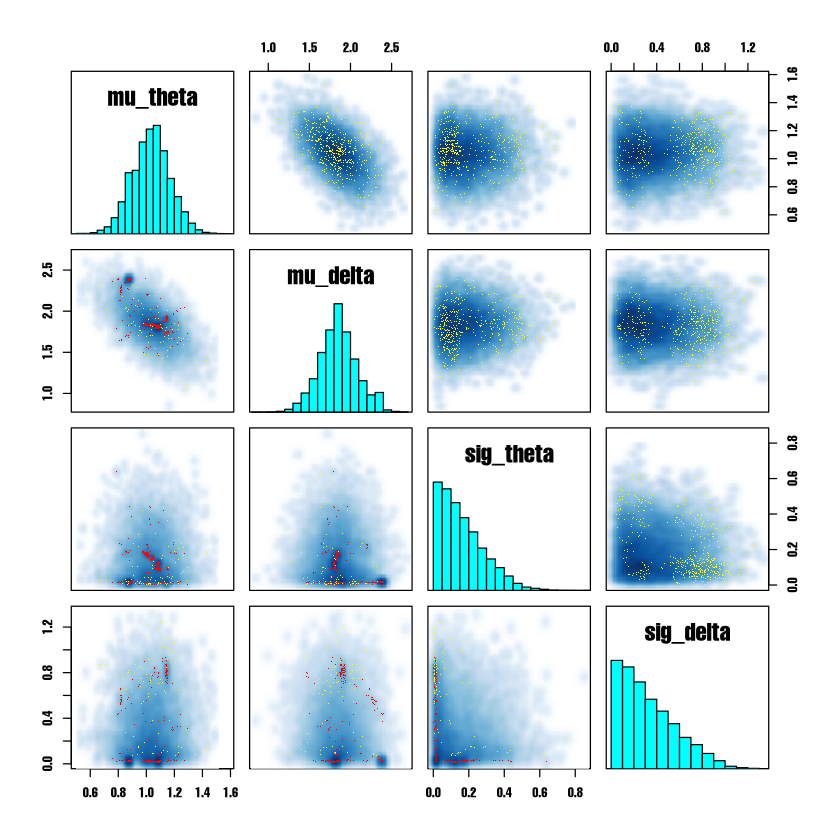

In [3]:
library(bayesplot)
pairs(fit,pars=c('mu_theta','mu_delta','sig_theta','sig_delta'))

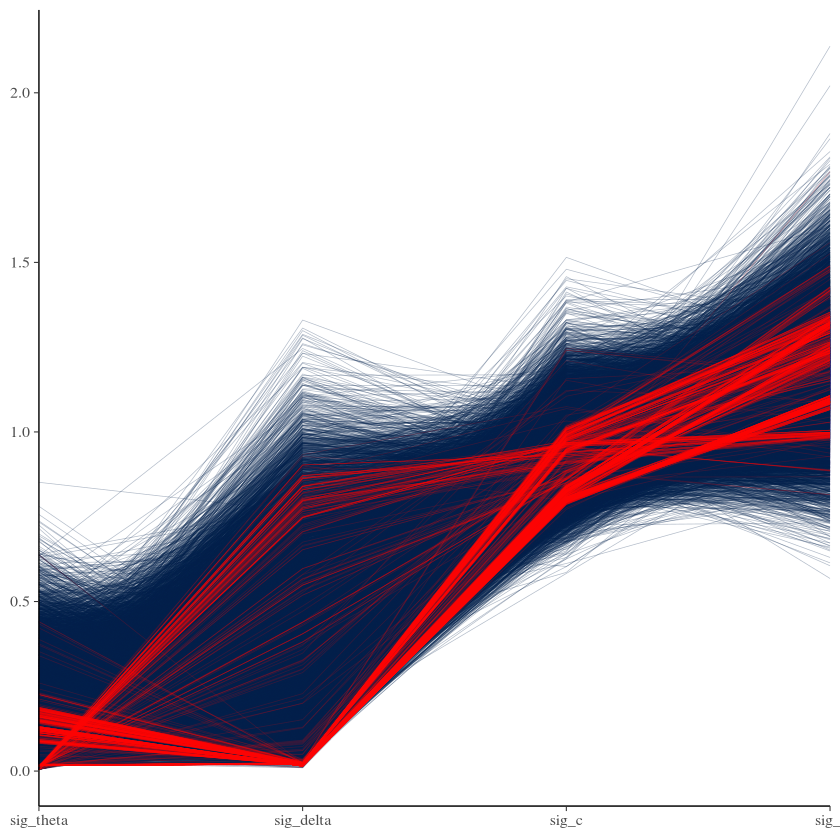

In [4]:
np = nuts_params(fit)
mcmc_parcoord(as.array(fit),pars=c('sig_theta','sig_delta','sig_c','sig_t'),np=np)

### The Problem with Variances
Let's consider the conditional posterior over $\sigma{\theta}$:
$$
\begin{split}
P[\sigma_{\delta}| \mu_{\theta},\mu_{\delta},\sigma_{\theta},\sigma_{c},\sigma_{t}] &\propto \prod_i N(\delta_i; \mu_{\delta}, \sigma_{\delta}))\\
&\propto \prod_i  \exp \left[-\frac{(\delta_i - \mu_{\delta})^2}{2 \sigma_{\delta}^2}\right]\\
\end{split}
$$

Oh the posterior density has a "singularity" when $\sigma_{\delta}=0$ (not precisely, since the posterior density goes to 0, but it this will happen "sharply"). What effect will this have on HMC?

Recall that the Hamiltonian system simulated in HMC is given by:
$$
\begin{split}
\frac{d \theta}{dt} &= M^{-1} p\\
\frac{d p}{dt} &= \nabla_{\theta} \ln(f(\theta)) \\ 
\end{split}
$$ 
What does $ \frac{d}{d \sigma_{\delta}} \ln \left( P[\sigma_{\delta}| \mu_{\theta},\mu_{\delta},\sigma_{\theta},\sigma_{c},\sigma_{t}] \right)$ look like?
$$
\frac{d}{d \sigma_{\delta}} \left[-\frac{(\delta_i - \mu_{\delta})^2}{2 \sigma_{\delta}^2}\right] = \frac{-1}{\sigma_{\delta}^3} \left[-(\delta_i - \mu_{\delta})^2\right] 
$$
So the right hand side of our ODE system has a singularity at $\sigma_{\delta}=0$. This will produce highly curved trajectories. Recall from Calc 3 that the curvature of the trajectory $\theta_t$ is given $k(\theta_t) = ||\frac{d}{dt}T(\theta_t)||$ where $T(\theta_t)$ is the tangent vector to $\theta_t$, ie. $T(\theta_t)=p_t$. Thus $||\frac{d}{dt} T(\theta_t)|| = ||\frac{d}{dt} p_t || = ||\nabla_{\theta} \ln(f(\theta))||$. The curvature of the proposal trajectories is just the norm of the gradient of the log-posterior, thus if the log-posterior blows up to infinity, then the proposal trajectory will become infinitely curved.

We can see how this curvature manifests in HMC by recalling the leapfrog solver:
$$
\begin{split}
p_{k}^{(t+\epsilon/2)} &= p_k^{(t)} - \frac{\epsilon}{2} \nabla_{\theta=\theta_k^{(t)}} Q(\theta)\\  
\theta_{k}^{(t+\epsilon)} &= \theta_k^{(t)} + \epsilon M^{-1} p_{k}^{(t+\epsilon/2)}\\
p_{k}^{(t+\epsilon)} &= p_k^{(t)} - \frac{\epsilon}{2} \nabla_{\theta=\theta_k^{(t+\epsilon)}} Q(\theta)\\  
\end{split}
$$
We see that here the singularity will cause the solved trajectory to diverge to infinity. The `NUTS` sampler will attempt to compensate for this by taking increasingly small numerical steps $\epsilon$, however as $\sigma_{\delta}$ goes closer to 0 it will be unable to completely control the solver, producing the divergent transition.

### Non-Centered Parameterization
It turns out that fixing the divergences is actually somewhat simple, we just need to reparameterize our model. We'll say that $\delta_i = \mu_{\delta} + \tau_i^{\delta}\sigma_{\delta}$, and that $\tau_{\delta} \sim N(0,1)$ (and similarly for $\theta_i$). Our model is then:

$$
\begin{split}
\text{control: }x_{i} &\sim N(\mu_{\theta} + \tau_i^{\theta}\sigma_{\theta},\sigma_c^2)\\
\text{drug treatment: }y_{i} &\sim N(\mu_{\theta} + \tau_i^{\theta}\sigma_{\theta} + \mu_{\delta} + \tau_i^{\delta}\sigma_{\delta},\sigma_t^2)\\
\end{split}
$$

With priors:
$$
\begin{split}
\tau_i^{\theta} &\sim N(0,1)\\
\tau_i^{\delta} &\sim N(0,1)\\
\sigma_c &\sim IG(1,10)\\
\sigma_t &\sim IG(1,10)\\
\end{split}
$$

And the same hyperpriors:
$$
\begin{split}
\mu_{\theta} &\sim N(0,20)\\
\mu_{\delta} &\sim N(0,20)\\
\sigma_{\theta}^2 &\sim \text{unif}(0,10^6)\\
\sigma_{\delta}^2 &\sim \text{unif}(0,10^6)\\
\end{split}
$$

Why does this work? Let's look at the new conditional density over $\sigma_{\delta}$:
$$
\begin{split}
P[\sigma_{\delta}| \mu_{\theta},\mu_{\delta},\sigma_{\theta},\sigma_{c},\sigma_{t}] &\propto \prod_i N(y_i; \theta_i + \mu_\delta + \tau_i^{\delta} \sigma_{\delta}, \sigma_t)\\
&\propto \prod_i \exp \left[ \frac{(y_i - \theta_i + \mu_\delta + \tau_i^{\delta} \sigma_{\delta})^2 }{2 \sigma_t^2} \right]
\end{split}
$$
This parameterization has "moved" the $\sigma_{\delta}$ up from the denominator of the log-posterior to the numerator, thus removing the singularity.

In [5]:
library(rstan)
set.seed(8675309)
stan.mod.ncp = "
data {
  int I; // number of trials
  vector[I] x; // control outcomes
  vector[I] y; // drug outcomes
}

parameters {
  // model parameters
  vector[I] tau_theta;
  vector[I] tau_delta;
  real<lower=0> sig_c;
  real<lower=0> sig_t;

  // hyperparameters
  real mu_theta;
  real mu_delta;
  real<lower=0> sig_theta;
  real<lower=0> sig_delta; 
}

transformed parameters {
  vector[I] theta;
  vector[I] delta;

  theta = mu_theta + tau_theta*sig_theta;
  delta = mu_delta + tau_delta*sig_delta;
}

model {
  // hyperpriors
  // Stan defaults to improper uniform priors:
  //mu_theta ~ normal(0,20); 
  //mu_delta ~ normal(0,20); 

  sig_delta ~ uniform(0,1e6);
  sig_theta ~ uniform(0,1e6); 

  // model priors 
  tau_theta ~ normal(0,1);
  tau_delta ~ normal(0,1);

  sig_c ~ inv_gamma(1,10);
  sig_t ~ inv_gamma(1,10);

  // likelihood
  x ~ normal(theta,sig_c);
  y ~ normal(delta,sig_t);
}
"

fit.ncp = stan(model_code = stan.mod.ncp,
           data=stan.dat,
           chains=chains,
           iter=nsamps,
           seed=seed,
           control=list(adapt_delta=0.99) )



SAMPLING FOR MODEL 'a3ec81714638c2ce30117fa0f5af6613' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.42732 seconds (Warm-up)
Chain 1:                4.40908 seconds 

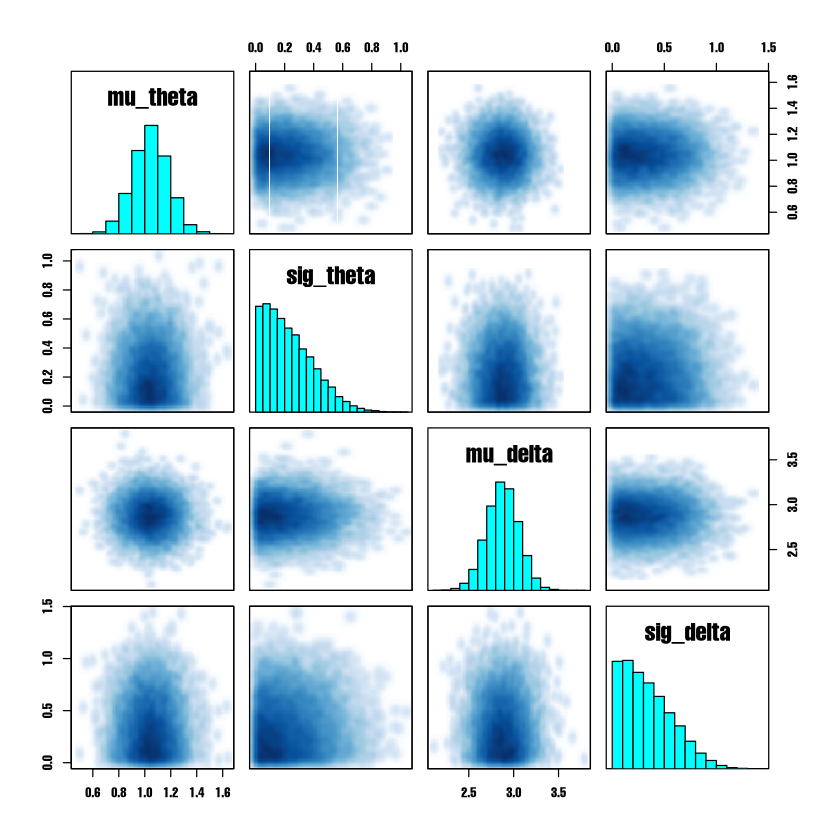

In [116]:
pairs(fit.ncp,pars=c('mu_theta','sig_theta','mu_delta','sig_delta'))

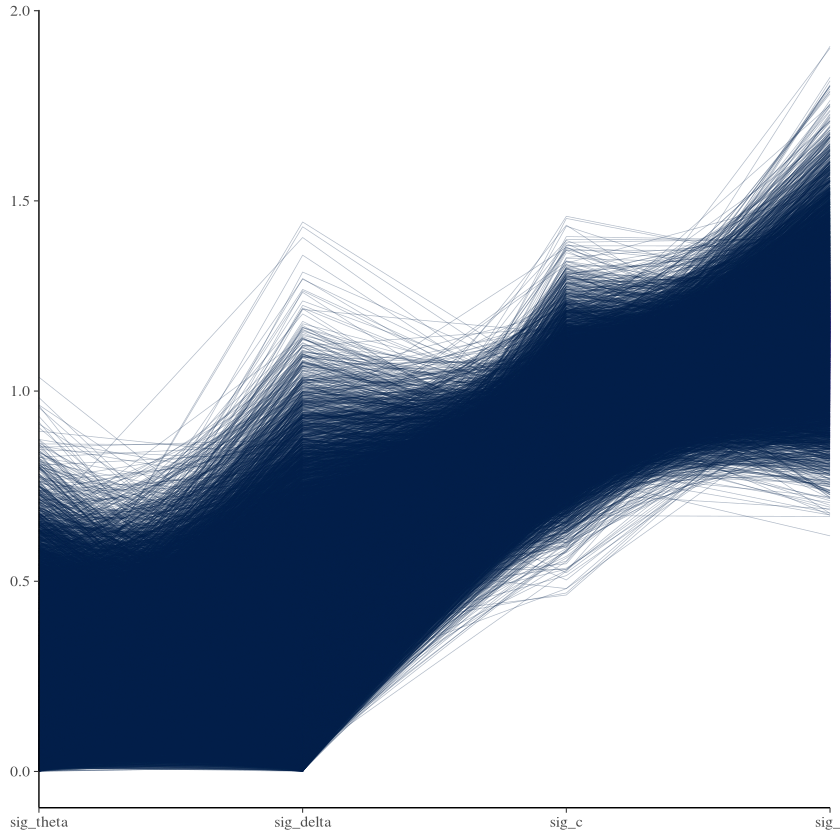

In [120]:
np.ncp = nuts_params(fit.ncp)
mcmc_parcoord(as.array(fit.ncp),pars=c('sig_theta','sig_delta','sig_c','sig_t'),np=np.ncp)

## ODEs in `Stan`
#### Example borrowed from [Dominic Steinitz](https://idontgetoutmuch.wordpress.com/2016/01/15/inferring-parameters-for-odes-using-stan/)
`Stan` has the functionality to solve ODEs within the sampler. Let's illustrate how to do this using te sample of a simple pendulum, being forced by Gaussian white noise:
$$
\frac{d^2 \alpha}{dt^2} = -g \sin \alpha + w(t)
$$
Where $w(t)$ is a function which takes time as an input, and returns the a random value drawn from a standard normal distribution. A simple discretizaiton of this using Euler's method is:
$$
\left[
\begin{matrix}
\alpha_k\\
\dot{\alpha}_k\\
\end{matrix}
\right] = 
\left[
\begin{matrix}
\alpha_{k-1} + \dot{\alpha}_{k-1} \epsilon\\
\dot{\alpha}_{k-1} - g \sin \alpha_{k-1} \epsilon\\
\end{matrix}
\right] + q_{k-1}
$$
Where $q_k \sim N(0,Q)$, with covariance matrix Q given:
$$
\left[
\begin{matrix}
\frac{1}{3}q^c \epsilon^3 & \frac{1}{2} q^c \epsilon^2\\
\frac{1}{2} q^c \epsilon^2 & q^c \epsilon\\
\end{matrix}
\right]
$$

We're not going to worry about where this $Q$ matrix comes from, for now let's just treat it as given. Let's say that we're Bayesian scientists in the early 18th century (with access to a computer fro 2020 which conveniently can run `R` and `Stan`), and we wish to estimate $g$ using a pendulum setup. We'll say that during the experiment we record the horizontal displacement with our 18th century hi-speed camera. While this sensor is fairly precise, it will record the horizontal displacement with some error. This model therefore has the form:
$$
\begin{split}
a_t &\sim P[\hat{a}_t|a_0,g]\\ 
z_t &\sim N( \sin(a_t), \sigma_z) \\
\end{split}
$$
Where $\hat{a}_t$ is the ODE trajectory with parameter $g$, initial conditions $a_0$.
With priors:
$$
\begin{split}
g &\sim N_+(0,20)\\
\sigma_z &\sim \chi^{-2}(0.5)\\
\end{split}
$$

Here's our `Stan` model code:

In [95]:
pendulum.mod = '
functions {
  real[] pendulum(real t, // time
                  real[] a, //state
                  real[] theta, // ODE params
                  real[] x_r, // real-valued ODE data
                  int[] x_i) { // integer-valued ODE data
    real dadt[2];
    dadt[1] = a[2];
    dadt[2] = - theta[1] * sin(a[1]);
    return dadt;
  }
}

data {
  int T; // number of timepoints recorded
  real y0[2]; // inital state of the system
  real z[T]; // observed horizontal displacements
  real t0; // initial timepoint of the system
  real ts[T]; // vector timepoints at which system was observed
}

transformed data {
  real x_r[0]; // empty data to pass to solver 
  int x_i[0];
}

parameters {
  real<lower=0> g[1]; // gravitational acceleration
  real<lower=0> sigma; //observation noise
}

model {
  real y_hat[T,2]; // variable to hold ODE solution

  g ~ normal(10,20);
  sigma ~ inv_chi_square(.5);

  y_hat = integrate_ode_rk45(pendulum, y0, t0, ts, g, x_r, x_i);
  
  for (t in 1:T) {
    z[t] ~ normal(sin(y_hat[t,1]), sigma);
  }
}

' 

And now we generate some data and then fit:

In [96]:
library(mvtnorm)

set.seed(8675309)

# generate our data 
qc = 0.0001
eps = 0.01
T = 100
y0 = c(1.6, 0)
g = 9.81
t0 = 0.0
ts = seq(eps,eps*T,eps)

Q = matrix(c(qc * eps^3 / 3, qc * eps^2 / 2,
             qc * eps^2 / 2, qc * eps),
           nrow = 2,ncol = 2,byrow = TRUE)

 
euler = function(init,eps,ts,Q,g){
    ret = matrix(0,nrow=length(ts),ncol=2)
    ret[1,] = init
    for (t in 2:nrow(ret)){
        q = rmvnorm(1,c(0,0),Q)

        a = ret[t-1,1]
        aDot = ret[t-1,2]
        
        ret[t,1] = a + eps*aDot + q[1]
        ret[t,2] = aDot - eps*g*sin(a) + q[2]  
    }   
    return(ret)
}

observations = euler(y0,eps,ts,Q,g)

sigz = .01
z = sin(observations[,1]) + rnorm(length(ts),0,sigz)

stan.dat = list('T'=length(ts),
                'y0'=y0,
                'z'=z, 
                't0'=-eps,
                'ts'=ts)
fit = stan(model_code = pendulum.mod,
           data=stan.dat,
           chains=chains,
           iter=nsamps,
           seed=seed)



SAMPLING FOR MODEL '4c279a2b97f51e8513a446ad8915904d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000186 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.86 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.94879 seconds (Warm-up)
Chain 1:                3.24388 seconds

Now we diagnose and check our fit:

[1] "Gelman-Rubin:"


g[1]     sigma      lp__ 
1.0000223 0.9999355 1.0001768

[1] "Posterior mean for g"


[1] 9.174724

[1] "Posterior quantiles for g"


5%      95% 
9.128185 9.221024

[1] "Posterior mean for sigma_z"


[1] 0.02435289

[1] "Posterior quantiles for sigma_z"


5%        95% 
0.02154538 0.02752641

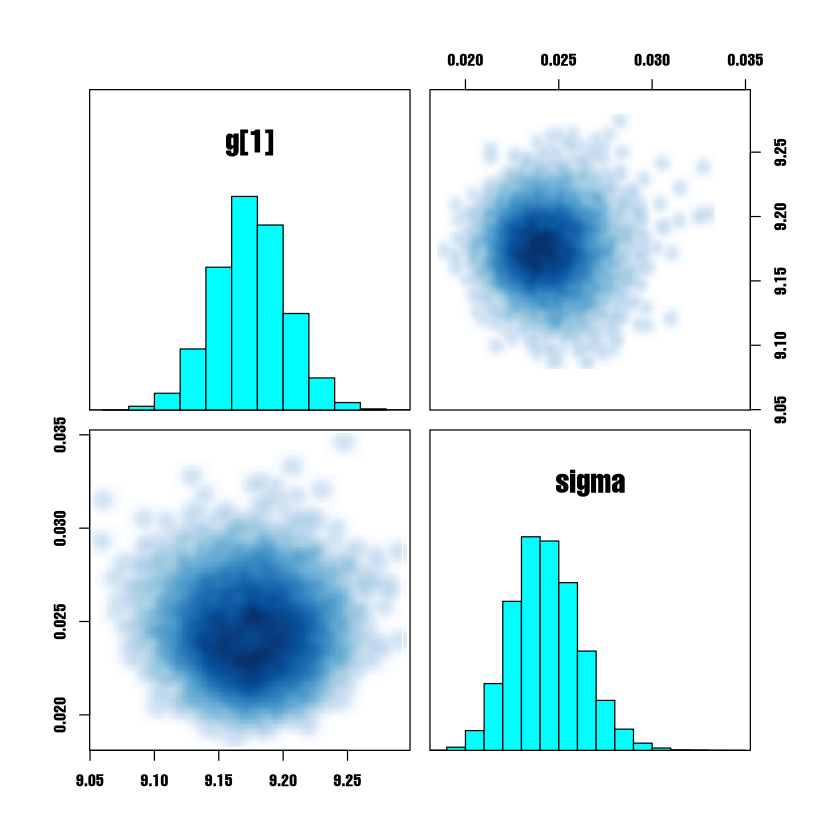

In [90]:
print('Gelman-Rubin:')
rhat(fit)

samps = extract(fit)
print('Posterior mean for g')
mean(unlist(samps['g']))
print('Posterior quantiles for g')
quantile(unlist(samps['g']),c(.05,.95))

print('Posterior mean for sigma_z')
mean(unlist(samps['sigma']))
print('Posterior quantiles for sigma_z')
quantile(unlist(samps['sigma']),c(.05,.95))

pairs(fit,pars=c('g','sigma'))